In [1]:
from scipy import *
from numpy import *
from scipy.interpolate import interp1d
from scipy import optimize
from matplotlib import pyplot as plt
import os,sys

In [2]:
################################
########## PARAMETERS ##########

##------ General -------##

# Prefactor of the MSD (in µm^2/s^0.5)
G = 0.001627 # Measured on 5-sec resolution traces taken before (n=11) and after (n=8) the 30'-PR experiments of 20210723

kT = 1.3806e-23 * 310. /1e-12/1e-6 # in pN.µm


##------ 10x 100sec-pull/release data -------##

dataPath_100s='../data/2-trajectory_files/100s-PR/'
fnTracking="20200304_100s-PR_trajectory.trk2"
fnFxyz="20200304_100s-PR_Fxyz.csv"

pixelSize=0.129 # um
dt=5 # sec
delaySwitchMagnet=dt-1 # Delay in sec between placement/removal of magnet and acquisition of image


##------ Display -------##

colors={'force':          '#f07100',
        'diffusion_fill': '#00000010',
        'pred':           '#606060',
        'unexpl':         '#000000',
        'lateral':        '#5480a6'}

cm_traj_100s=plt.cm.colors.LinearSegmentedColormap('cm_traj_100s',
    {'red':   ((0,.0,.0),(.5,.3,.3),(1,.6,.6)),
     'green': ((0,.3,.3),(.5,.6,.6),(1,.6,.6)),
     'blue':  ((0,.2,.2),(.5,.0,.0),(1,.1,.1))})

cm_tangentSpeed=plt.cm.colors.LinearSegmentedColormap('cm_traj_30min',
    {'red':   ((0,.4,.4),(1,.25,.25)),
     'green': ((0,.4,.4),(1,.6,.6)),
     'blue':  ((0,.4,.4),(1,.9,.9))})

cm_tangentSpeed2=plt.cm.colors.LinearSegmentedColormap('cm_traj_30min',
    {'red':   ((0,.4,.4),(1,.59,.59)),
     'green': ((0,.4,.4),(1,.31,.31)),
     'blue':  ((0,.4,.4),(1,.9,.9))})

################################
################################

In [3]:
##------ Load 10x 100sec-pull/release data -------##

dataTracking=loadtxt(dataPath_100s+fnTracking)
# 0:frame  1:X  2:Y  3:Z   4:fluo  5:bg  6:bgTiltX  7:bgTiltY  8:bgTiltZ  9(bits: spot detected, fit convereged)

Fxyz=loadtxt(dataPath_100s+fnFxyz,skiprows=1,delimiter=';')[:,1:] # in pN
 
# Time
t=dataTracking[:,0]*dt+delaySwitchMagnet

# Position
pos=dataTracking[:,1:3]*pixelSize
pos-=pos[:20].mean(0) # Center on origin

# Frame index of each pull and each release
indPull   =where(diff((Fxyz[:,0]!=0)*1)==1)[0]+1
indRelease=where(diff((Fxyz[:,0]!=0)*1)==-1)[0]+1
tPull=indPull*dt; tRelease=indRelease*dt; 


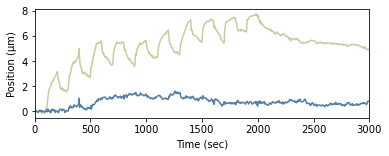

In [4]:
plt.figure(figsize=(6,2))
plt.plot(t,-pos[:,1],color='#c0d0a0')
plt.plot(t,pos[:,0],color=colors['lateral'])
plt.ylabel("Position (µm)"); plt.ylim(-.5,);
plt.xlabel('Time (sec)'); plt.xlim(0,3000);
#plt.show()
plt.savefig('fig_SI_MSDs_traj.pdf')


Fitted $\Gamma$ : 0.0019774025749612423 +- 4.135164609332934e-05


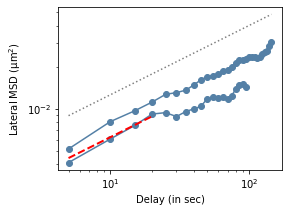

In [5]:
plt.figure(figsize=(4,3))

#-----------------------

ind = (400,600) # Timepoints to use
maxlagDisp = 30

t_msd = arange(1, maxlagDisp)*dt
msd = array([mean((pos[ind[0]:ind[1]-lag, 0]-pos[(ind[0]+lag):ind[1], 0])**2) for lag in range(1, maxlagDisp)])
plt.plot(t_msd, msd,marker='o',c='#5480a6')
plt.plot(t_msd, 0.004*t_msd**0.5,c='gray',ls=':')

#-----------------------

ind = (500,600) # Timepoints to use
maxlagDisp = 20
maxlagFit = 4

t_msd = arange(1, maxlagDisp)*dt
msd = array([mean((pos[ind[0]:ind[1]-lag, 0]-pos[(ind[0]+lag):ind[1], 0])**2) for lag in range(1, maxlagDisp)])

G_MSD, G_MSDvar = optimize.curve_fit(lambda t,G : G*sqrt(t), t_msd[:maxlagFit], msd[:maxlagFit], p0=0.002)
print("Fitted $\Gamma$ :", G_MSD[0], "+-", sqrt(G_MSDvar[0, 0]))

plt.plot(t_msd, msd, marker='o',c='#5480a6')
plt.plot(t_msd[:maxlagFit], G_MSD*t_msd[:maxlagFit]**0.5,c='r',ls='--',lw=2)

#-----------------------

plt.xlabel('Delay (in sec)'); plt.xscale('log')
plt.ylabel('Lateral MSD (µm$^2$)'); plt.yscale('log')
#plt.show()
plt.savefig('fig_SI_MSDs_lastRelease.pdf')



[]

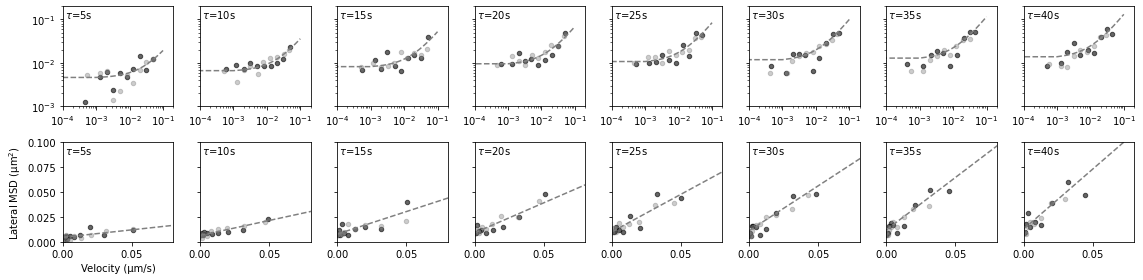

In [6]:
# Calculate tangential speed and orthogonal square distance,
#  for every pair of timepoints separated by `i` timesteps.
#  - Input: x: XY coordinates of trajectory as columns. i:number of timesteps.
#  - Returns: tau, velocity (along force), square displacement (orthogonal), as columns
calc_tau_v_sd=lambda x,i: array((dt*i*ones(x.shape[0]-i),
                                 (x[i:,1]-x[:x.shape[0]-i,1])/(dt*i),
                                 (x[i:,0]-x[:x.shape[0]-i,0])**2)
                               ).T

# Binning:
#  - Input: tvs:output from `calc_tau_v_sd()`. n:number of points to bin together
#  - Returns: a version of tvs, sorted based on velocity, where values are binned n by n
bin_tau_v_sd=lambda tvs,n: tvs[tvs[:,1].argsort()][-(tvs.shape[0]//n)*n:].reshape(-1,n,3).mean(1)

def bin_tau_v_sd_2(tvs,vbins):
    tvs_bin=[]
    for i in range(vbins.shape[0]-1):
        w=where((vbins[i]<tvs[:,1])*(tvs[:,1]<=vbins[i+1]))[0]
        if len(w): tvs_bin.append((tvs[w]).mean(0))
    return array(tvs_bin)


lDt=r_[1,2,3,4,5,6,7,8]

fig,ax=plt.subplots(2,len(lDt),sharex='row',sharey='row',figsize=(len(lDt)*2,4))
for i in range(len(lDt)):
    
    tvs=calc_tau_v_sd(pos[:]*r_[1,-1],lDt[i]);
    #tvs=concatenate([calc_tau_v_sd(pos[i0:i1],lDt[i]) for i0,i1 in zip(indPull,indRelease)]+
    #                [calc_tau_v_sd(pos[i0:i1],lDt[i]) for i0,i1 in zip(r_[0,indRelease],r_[indPull,pos.shape[0]])])
    #tvs=calc_tau_v_sd(pos[2000//dt:],1+i);
    
    #tvs_bin=bin_tau_v_sd(tvs,25)
    vbins=10**r_[-3:-1:.2]; tvs_bin=bin_tau_v_sd_2(tvs,r_[-vbins[::-1],0,vbins])
    #vbins=r_[-.1:.1:.007];  tvs_bin=bin_tau_v_sd_2(tvs,vbins)

    plt.sca(ax[0,i])
    plt.text(.02,.98,'$\\tau$=%ds'%(lDt[i]*dt),verticalalignment='top',transform=plt.gca().transAxes)
    plt.scatter(tvs_bin[:,1], tvs_bin[:,2],alpha=.6,c='k',s=20)
    plt.scatter(-tvs_bin[:,1],tvs_bin[:,2],alpha=.4,c='gray',s=20)
    vCoo=r_[:.1:1e-3]; plt.plot(vCoo,0.002*(dt*lDt[i])**.5+.03*vCoo*(dt*lDt[i])**1,c='gray',ls='--')
    plt.xscale('log'); plt.xlim(1e-4,.2); plt.yscale('log'); plt.ylim(1e-3,.2)

    plt.sca(ax[1,i])
    plt.text(.02,.98,'$\\tau$=%ds'%(lDt[i]*dt),verticalalignment='top',transform=plt.gca().transAxes)
    plt.scatter(tvs_bin[:,1], tvs_bin[:,2],alpha=.6,c='k',s=20)
    plt.scatter(-tvs_bin[:,1],tvs_bin[:,2],alpha=.4,c='gray',s=20)
    #vCoo=r_[:.1:1e-3]; plt.plot(vCoo,(0.002+.15*vCoo)*(dt*lDt[i])**.5,c='gray',ls='--')
    vCoo=r_[:.1:1e-3]; plt.plot(vCoo,0.002*(dt*lDt[i])**.5+.03*vCoo*(dt*lDt[i])**1,c='gray',ls='--')
    plt.xlim(0,.08); plt.ylim(0,.1);

ax_=ax[-1,0]; ax_.set_xlabel("Velocity (µm/s)"); ax_.set_ylabel("Lateral MSD (µm$^2$)")
plt.tight_layout(); plt.plot()


G2 = 0.0382 µm


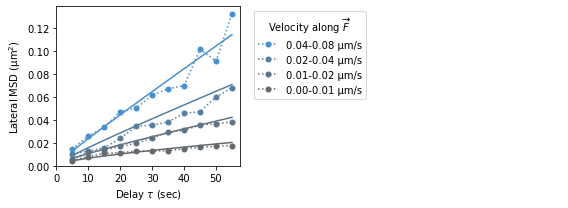

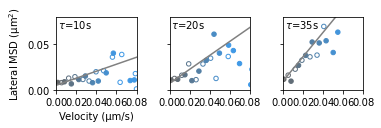

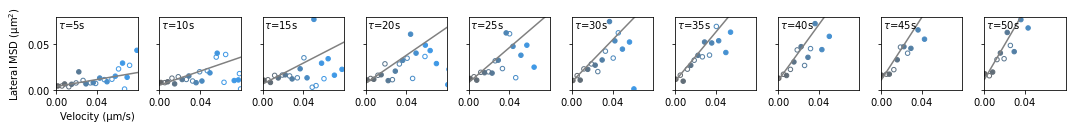

In [7]:
#---------------------------------#
lDt=r_[1:12]
vbins=r_[0,.01,.02,.04,.08]

tvs_all=array([bin_tau_v_sd_2(abs(calc_tau_v_sd(pos[:]*r_[1,-1],lDt[i])),vbins) for i in range(len(lDt))])
tau=lDt*dt

# Fit
from scipy import optimize
#G2,alpha=optimize.fmin(lambda p: sum((tvs_all[:,:,2] - (G*tvs_all[:,:,0]**.5 + p[0]*tvs_all[:,:,1]*tvs_all[:,:,0]**p[1]))**2), [0.03,1], disp=False)
#print("$\\alpha$ = %.2f, G2 = %.4f"%(alpha, G2))
G2=optimize.fmin(lambda G2: sum((tvs_all[:,:,2] - (G*tvs_all[:,:,0]**.5 + G2*tvs_all[:,:,1]*tvs_all[:,:,0]**1))**2), 0.03, disp=False)[0]
print("G2 = %.4f µm"%G2)

# Plot
fig,ax=plt.subplots(1,2,figsize=(8,3)); plt.sca(ax[0])
for i in range(vbins.shape[0]-1)[::-1]:
    v_mean=tvs_all[:,i,1].mean(0)
    plt.plot(tvs_all[:,i,0],tvs_all[:,i,2],marker='o',color=cm_tangentSpeed(v_mean/.06),ls=':',ms=5,label='%.2f-%.2f µm/s'%(vbins[i],vbins[i+1]))
    plt.plot(tau, G*tau**.5 + G2*v_mean*tau**1,  color=cm_tangentSpeed(v_mean/.06),ls='-')

plt.xlim(0,None); plt.ylim(0,None);
plt.legend(title='Velocity along $\overrightarrow{F}$', bbox_to_anchor=(1.05, 1))

plt.xlabel("Delay $\\tau$ (sec)"); plt.ylabel("Lateral MSD (µm$^2$)");
plt.sca(ax[1]); plt.axis('off')
plt.tight_layout();
plt.savefig('fig3_lateralMSDvsTau.pdf')

#---------------------------------#
lDt=r_[2,4,7]

vCoo=r_[:.1:1e-3]; 
fig,ax=plt.subplots(1,len(lDt),sharex='row',sharey='row',figsize=(len(lDt)*1.8,1.8))
for i in range(len(lDt)):
    tvs=calc_tau_v_sd(pos[:]*r_[1,-1],lDt[i]);
    vbins=r_[-.1:.1:.007];  tvs_bin=bin_tau_v_sd_2(tvs,vbins)
    tau=dt*lDt[i]

    plt.sca(ax[i])
    plt.text(.02,.98,'$\\tau$=%ds'%(lDt[i]*dt),verticalalignment='top',transform=plt.gca().transAxes)
    plt.scatter(tvs_bin[:,1], tvs_bin[:,2],                  color=cm_tangentSpeed(abs(tvs_bin[:,1])/.06),s=20)
    plt.scatter(-tvs_bin[:,1],tvs_bin[:,2],facecolors='none',color=cm_tangentSpeed(abs(tvs_bin[:,1])/.06),s=20)
    plt.plot(vCoo,G*tau**.5 + G2*vCoo*tau ,c='gray',ls='-')
    plt.xlim(0,0.08); plt.xticks([0,.02,.04,.06,.08])
    plt.ylim(0,.08);

ax_=ax[0]; ax_.set_xlabel("Velocity (µm/s)"); ax_.set_ylabel("Lateral MSD (µm$^2$)")
plt.tight_layout();
plt.savefig('fig3_lateralMSDvsV.pdf')

#---------------------------------#

lDt=r_[1:11]

vCoo=r_[:.1:1e-3]; 
fig,ax=plt.subplots(1,len(lDt),sharex='row',sharey='row',figsize=(len(lDt)*1.5,1.8))
for i in range(len(lDt)):
    tvs=calc_tau_v_sd(pos[:]*r_[1,-1],lDt[i]);
    vbins=r_[-.1:.1:.007];  tvs_bin=bin_tau_v_sd_2(tvs,vbins)
    tau=dt*lDt[i]

    plt.sca(ax[i])
    plt.text(.02,.98,'$\\tau$=%ds'%(lDt[i]*dt),verticalalignment='top',transform=plt.gca().transAxes)
    plt.scatter(tvs_bin[:,1], tvs_bin[:,2],                  color=cm_tangentSpeed(abs(tvs_bin[:,1])/.06),s=20)
    plt.scatter(-tvs_bin[:,1],tvs_bin[:,2],facecolors='none',color=cm_tangentSpeed(abs(tvs_bin[:,1])/.06),s=20)
    plt.plot(vCoo,G*tau**.5 + G2*vCoo*tau ,c='gray',ls='-')
    plt.xlim(0,0.08); plt.xticks([0,.04])
    plt.ylim(0,.08);

ax_=ax[0]; ax_.set_xlabel("Velocity (µm/s)"); ax_.set_ylabel("Lateral MSD (µm$^2$)")
plt.tight_layout();
#plt.show()
plt.savefig('fig_SI_lateralMSDvsV_all.pdf')

#---------------------------------#



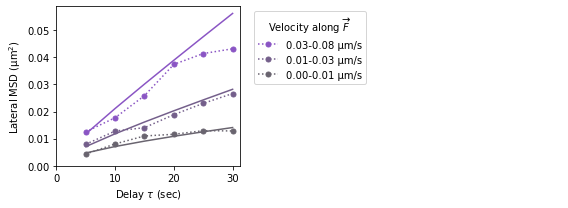

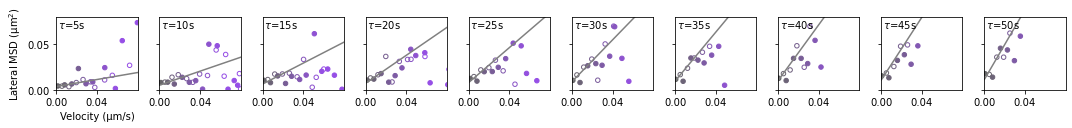

In [8]:
indStart=140
#---------------------------------#
lDt=r_[1:7]
vbins=r_[0,.01,.03,.08]

tvs_all=array([bin_tau_v_sd_2(abs(calc_tau_v_sd(pos[indStart:]*r_[1,-1],lDt[i])),vbins) for i in range(len(lDt))])
tau=lDt*dt


fig,ax=plt.subplots(1,2,figsize=(8,3)); plt.sca(ax[0])
for i in range(vbins.shape[0]-1)[::-1]:
    v_mean=tvs_all[:,i,1].mean(0)
    plt.plot(tvs_all[:,i,0],tvs_all[:,i,2],marker='o',color=cm_tangentSpeed2(v_mean/.06),ls=':',ms=5,label='%.2f-%.2f µm/s'%(vbins[i],vbins[i+1]))
    plt.plot(tau, 0.0018*tau**.5+.035*v_mean*tau**1,  color=cm_tangentSpeed2(v_mean/.06),ls='-')

plt.xlim(0,None); plt.ylim(0,None);
plt.legend(title='Velocity along $\overrightarrow{F}$', bbox_to_anchor=(1.05, 1))

plt.xlabel("Delay $\\tau$ (sec)"); plt.ylabel("Lateral MSD (µm$^2$)");
plt.sca(ax[1]); plt.axis('off')
plt.tight_layout();
plt.savefig('fig_SI_lateralMSDvsTau_from-P4.pdf')

#---------------------------------#
lDt=r_[1:11]

vCoo=r_[:.1:1e-3]; 
fig,ax=plt.subplots(1,len(lDt),sharex='row',sharey='row',figsize=(len(lDt)*1.5,1.8))
for i in range(len(lDt)):
    tvs=calc_tau_v_sd(pos[indStart:]*r_[1,-1],lDt[i]);
    vbins=r_[-.1:.1:.007];  tvs_bin=bin_tau_v_sd_2(tvs,vbins)
    tau=dt*lDt[i]

    plt.sca(ax[i])
    plt.text(.02,.98,'$\\tau$=%ds'%(lDt[i]*dt),verticalalignment='top',transform=plt.gca().transAxes)
    plt.scatter(tvs_bin[:,1], tvs_bin[:,2],                  color=cm_tangentSpeed2(abs(tvs_bin[:,1])/.06),s=20)
    plt.scatter(-tvs_bin[:,1],tvs_bin[:,2],facecolors='none',color=cm_tangentSpeed2(abs(tvs_bin[:,1])/.06),s=20)
    plt.plot(vCoo,G*tau**.5 + G2*vCoo*tau ,c='gray',ls='-')
    plt.xlim(0,0.08); plt.xticks([0,.04])
    plt.ylim(0,.08);

ax_=ax[0]; ax_.set_xlabel("Velocity (µm/s)"); ax_.set_ylabel("Lateral MSD (µm$^2$)")
plt.tight_layout();
#plt.show()
plt.savefig('fig_SI_lateralMSDvsV_from-P4.pdf')

#---------------------------------#


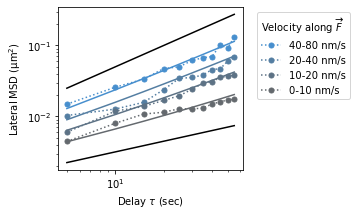

In [9]:
#---------------------------------#
lDt=r_[1:12]
vbins=r_[0,.01,.02,.04,.08]

tvs_all=array([bin_tau_v_sd_2(abs(calc_tau_v_sd(pos[:]*r_[1,-1],lDt[i])),vbins) for i in range(len(lDt))])
tau=lDt*dt


plt.figure(figsize=(3.3,3))
for i in range(vbins.shape[0]-1)[::-1]:
    v_mean=tvs_all[:,i,1].mean(0)
    plt.plot(tvs_all[:,i,0],tvs_all[:,i,2],marker='o',color=cm_tangentSpeed(v_mean/.06),ls=':',ms=5,label='%d-%d nm/s'%(1e3*vbins[i],1e3*vbins[i+1]))
    plt.plot(tau, G*tau**.5+G2*v_mean*tau**1,  color=cm_tangentSpeed(v_mean/.06),ls='-')

plt.plot(tau, 0.001*tau**.5,color='k'); plt.plot(tau, 0.005*tau**1,color='k')
#MSDfinal=(lambda x: array([mean((x[i:]-x[:-i])**2) for i in range(1,12)]))(pos[2400//dt:,0])
#plt.plot((r_[:MSDfinal.shape[0]]+1)*dt,MSDfinal,marker='o',color='k',ms=3)
plt.xscale('log'); plt.yscale('log');

#plt.xlim(0,None); plt.ylim(0,None);
plt.legend(title='Velocity along $\overrightarrow{F}$', bbox_to_anchor=(1.05, 1))
    
plt.xlabel("Delay $\\tau$ (sec)"); plt.ylabel("Lateral MSD (µm$^2$)");
plt.show()